In [60]:
from sklearn import tree
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz 
%matplotlib inline

In [61]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from IPython.display import SVG
from graphviz import Source
from IPython.display import display

In [62]:
from IPython.display import HTML
style = "<style>svg{width: 70% !important; height: 60% !important;} </style>"
HTML(style)

In [63]:
titanic_data = pd.read_csv('./input/train.csv')
titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [64]:
titanic_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [65]:
titanic_data["Age"] = titanic_data["Age"].fillna(titanic_data["Age"].median())

In [66]:
X = titanic_data.drop(['PassengerId','Survived','Name','Ticket','Cabin'], axis=1)
X = pd.get_dummies(X)

y = titanic_data.Survived

X.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,38.0,1,0,71.2833,1,0,1,0,0
2,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,35.0,1,0,53.1000,1,0,0,0,1
4,3,35.0,0,0,8.0500,0,1,0,0,1


In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [68]:
clf = tree.DecisionTreeClassifier(criterion='entropy')
clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

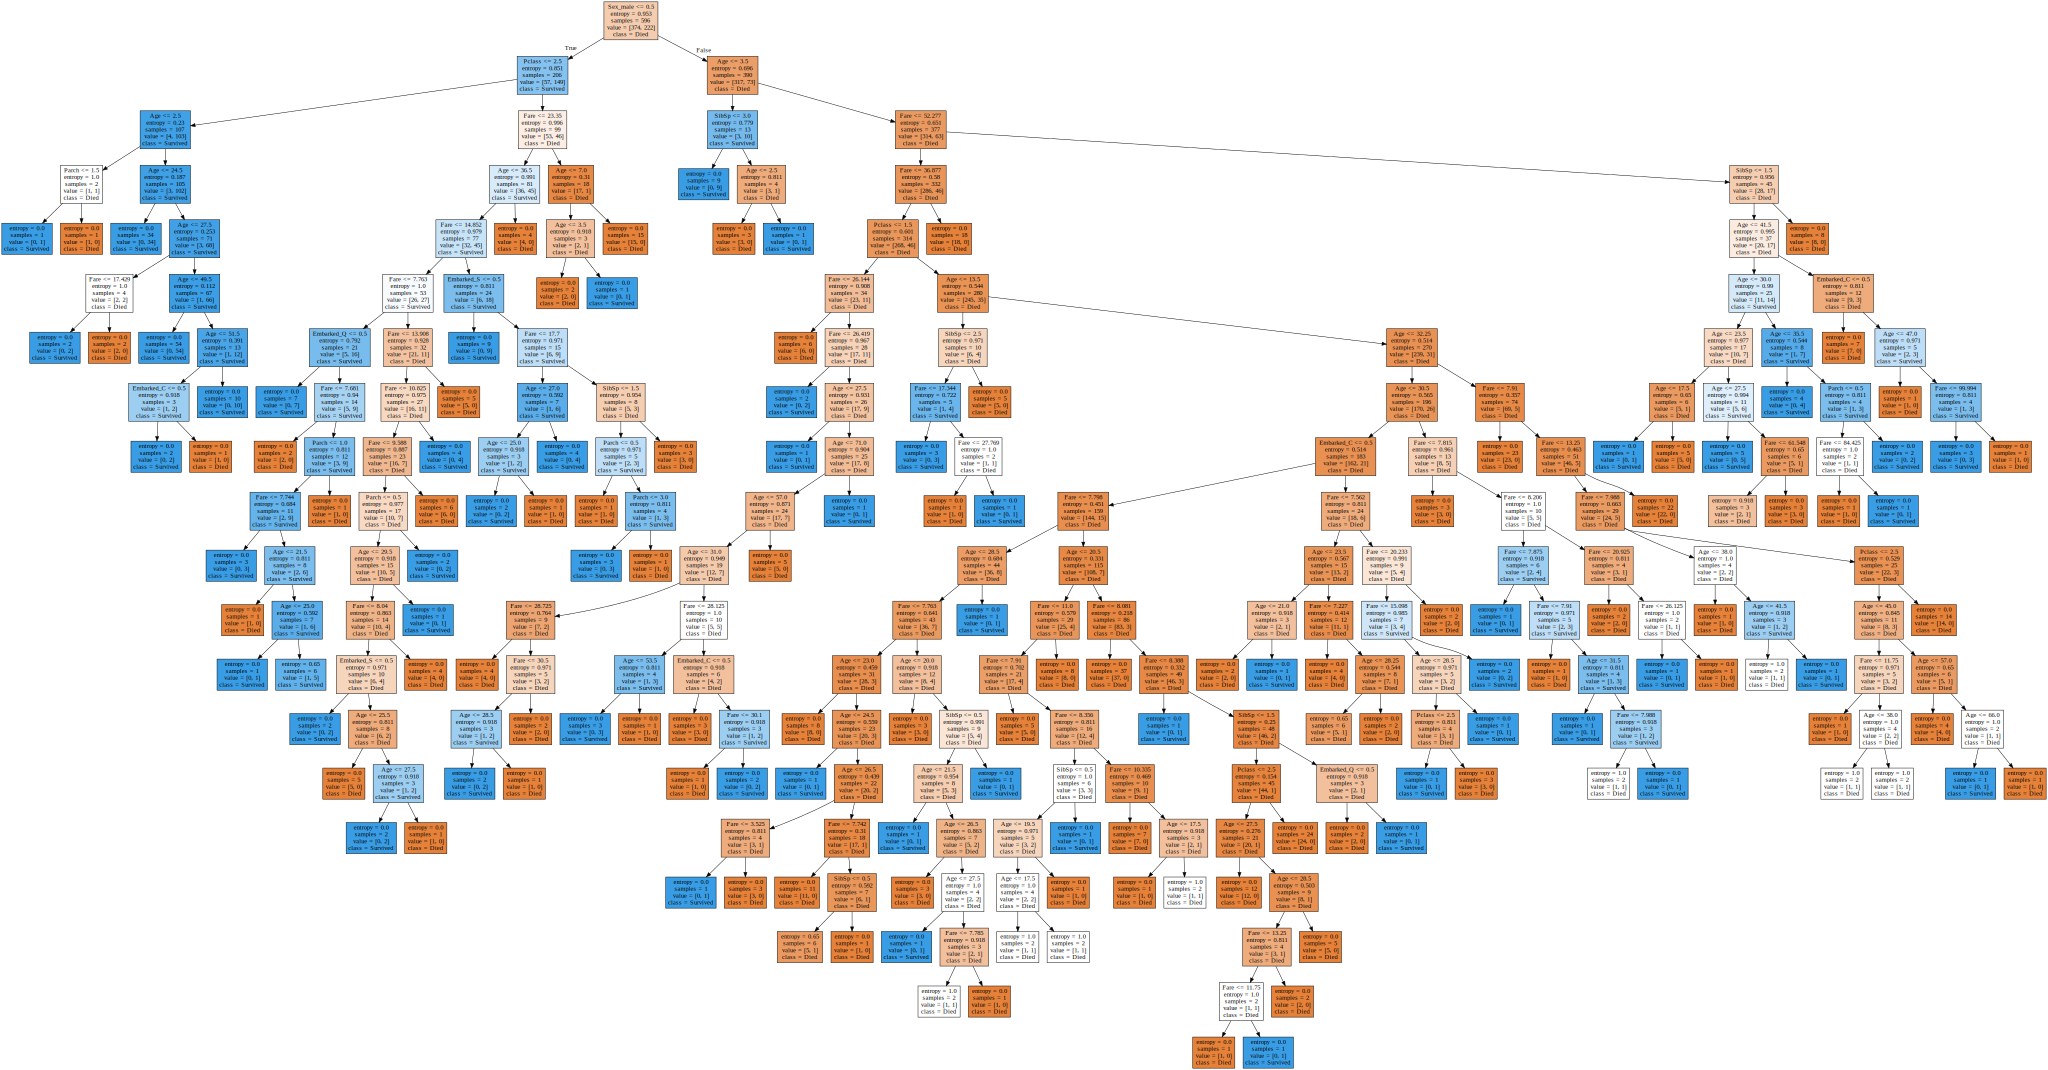

In [69]:
graph = Source(tree.export_graphviz(clf, out_file=None, feature_names=list(X), class_names=['Died', 'Survived'], filled=True))
display(SVG(graph.pipe(format='svg')))

In [70]:
max_depth_value = range (1, 100)
scores_data = pd.DataFrame()

for max_depth in max_depth_value:
    clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=max_depth)
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)
    mean_score = cross_val_score(clf, X_train, y_train, cv=5).mean()
    score_data = pd.DataFrame({'max_depth': [max_depth], 'train_score': [train_score], 'test_score': [test_score], 'mean_score': [mean_score]})
    
    scores_data = scores_data.append(score_data)

# scores_data.head()
scores_long_data = pd.melt(scores_data, id_vars=['max_depth'], value_vars=['train_score', 'test_score', 'mean_score'], var_name='set_type', value_name='score')

scores_long_data.head()

,max_depth,set_type,score
0,1,train_score,0.781879
1,2,train_score,0.805369
2,3,train_score,0.823826
3,4,train_score,0.833893
4,5,train_score,0.840604


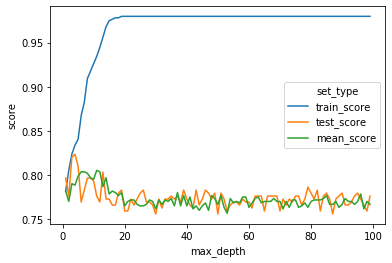

In [71]:
sns.lineplot(x='max_depth', y='score', hue='set_type', data=scores_long_data)

In [72]:
best_id = scores_long_data.query("set_type == 'mean_score'")['score'].idxmax()

best_depth = scores_long_data.loc[ best_id ,['max_depth', 'set_type', 'score'] ]['max_depth']
print(scores_long_data.loc[ best_id ,['max_depth', 'set_type', 'score'] ])

max_depth            11
set_type     mean_score
score          0.805392
Name: 208, dtype: object


In [73]:
best_clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=best_depth)
best_clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=11, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

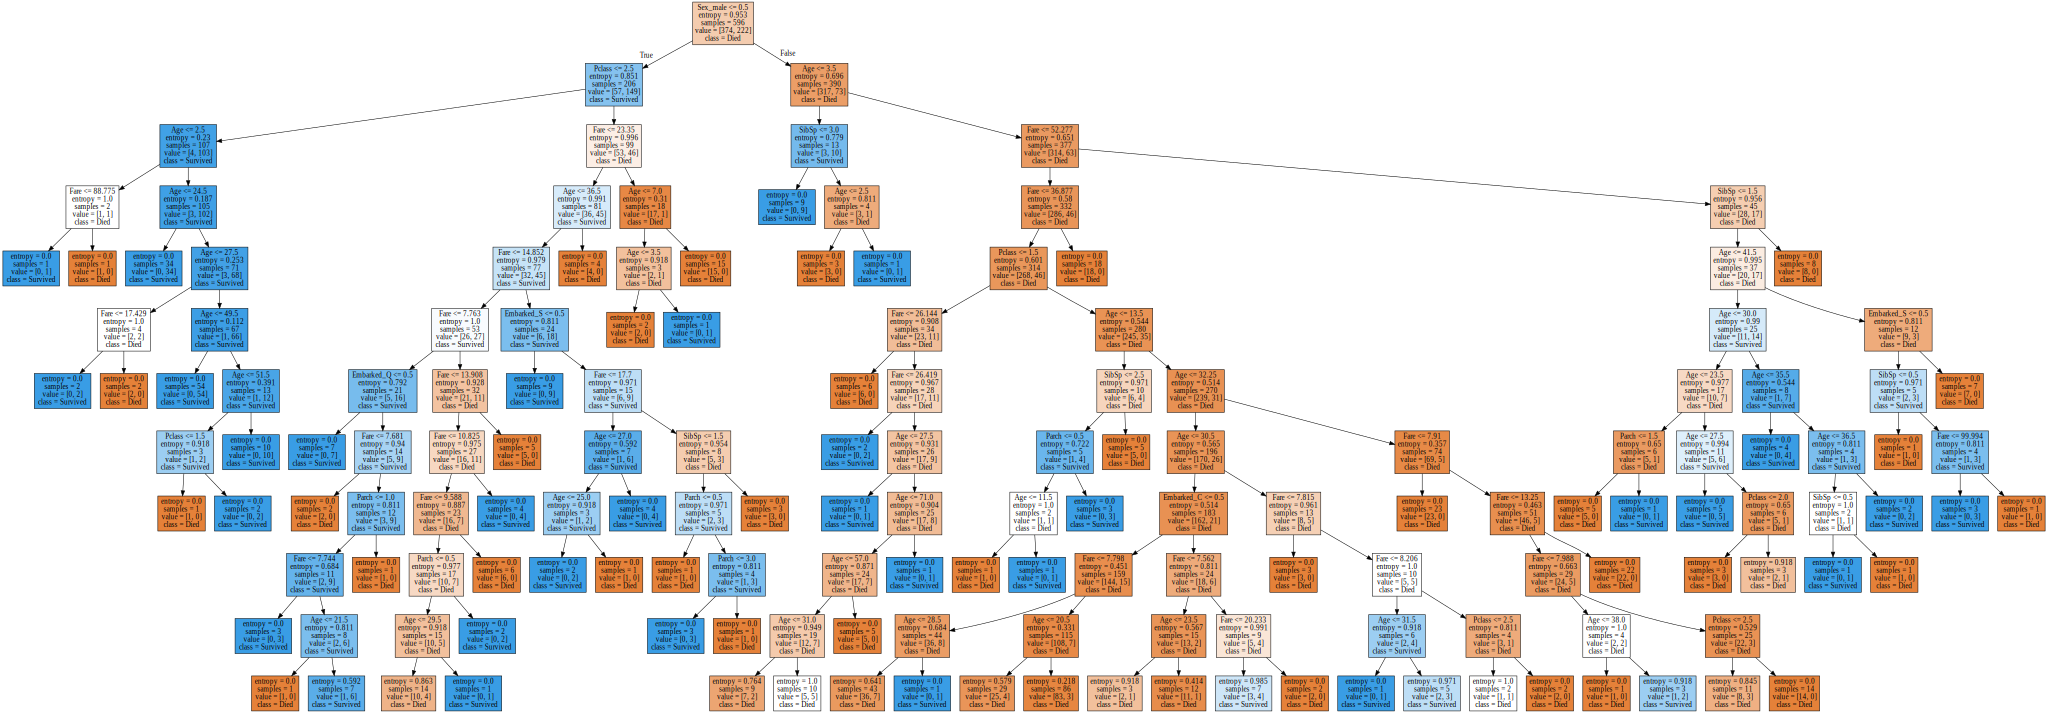

In [74]:
graph = Source(tree.export_graphviz(best_clf, out_file=None, feature_names=list(X), class_names=['Died', 'Survived'], filled=True))
display(SVG(graph.pipe(format='svg')))

In [75]:
min_samples_value = range (1, 100)
scores_data = pd.DataFrame()

for min_samples in min_samples_value:
    clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=best_depth, min_samples_leaf=min_samples)
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)
    mean_score = cross_val_score(clf, X_train, y_train, cv=5).mean()
    score_data = pd.DataFrame({'min_samples': [min_samples], 'train_score': [train_score], 'test_score': [test_score], 'mean_score': [mean_score]})
    
    scores_data = scores_data.append(score_data)

# scores_data.head()
scores_long_data = pd.melt(scores_data, id_vars=['min_samples'], value_vars=['train_score', 'test_score', 'mean_score'], var_name='set_type', value_name='score')
scores_long_data.head()

,min_samples,set_type,score
0,1,train_score,0.934564
1,2,train_score,0.911074
2,3,train_score,0.901007
3,4,train_score,0.894295
4,5,train_score,0.884228


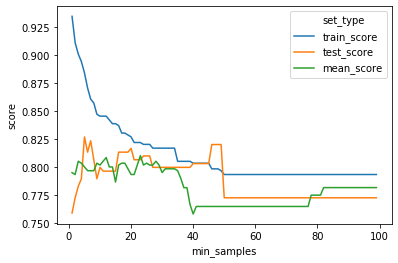

In [76]:
sns.lineplot(x='min_samples', y='score', hue='set_type', data=scores_long_data)

In [77]:
best_id = scores_long_data.query("set_type == 'mean_score'")['score'].idxmax()

best_min_samples = scores_long_data.loc[ best_id ,['min_samples', 'set_type', 'score'] ]['min_samples']
print(scores_long_data.loc[ best_id ,['min_samples', 'set_type', 'score'] ])

min_samples            23
set_type       mean_score
score            0.810448
Name: 220, dtype: object


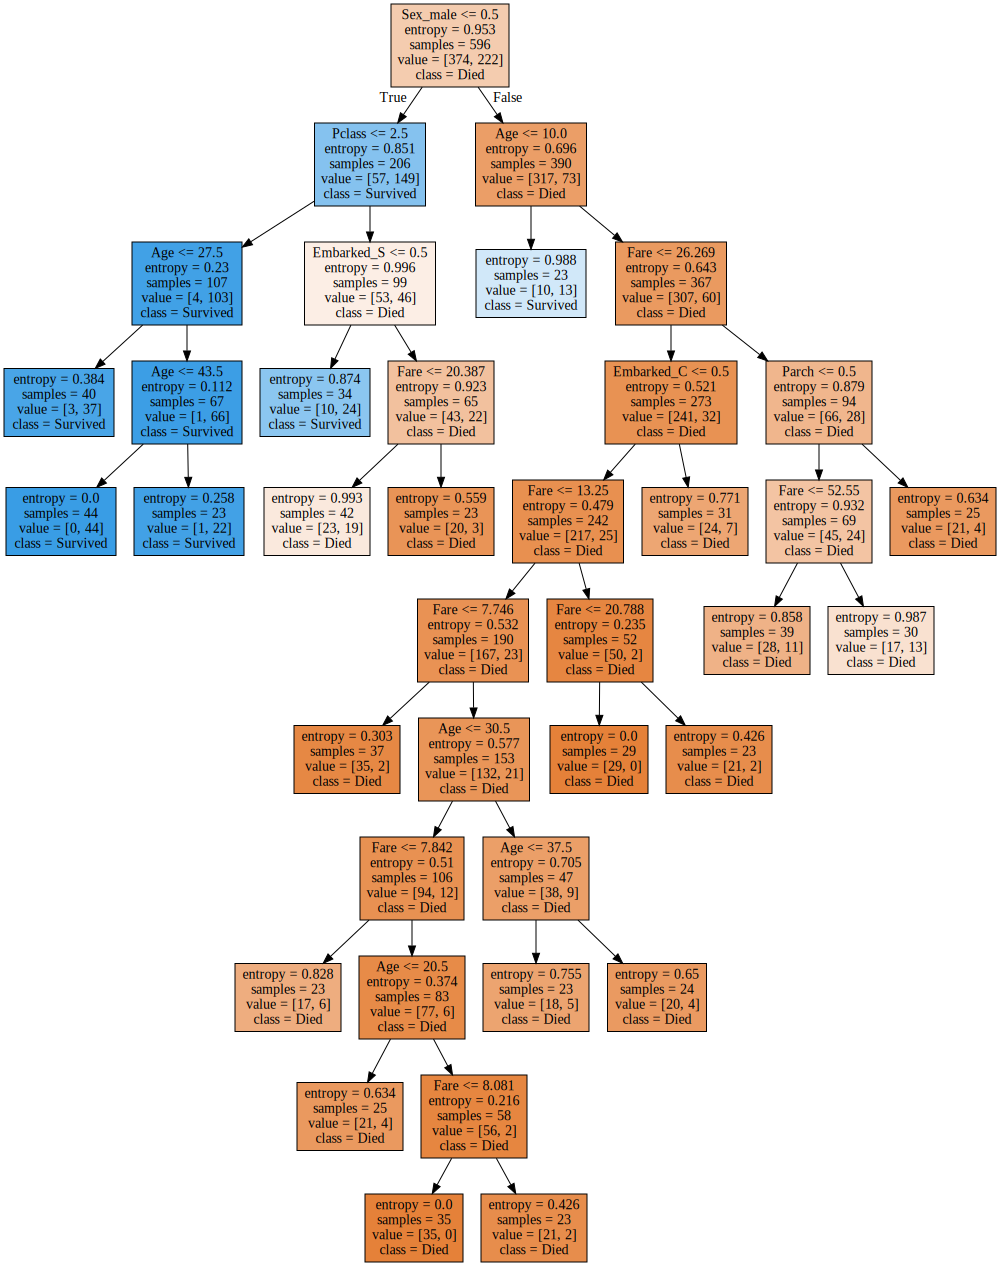

In [78]:
the_best_clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=best_depth, min_samples_leaf=best_min_samples)
the_best_clf.fit(X_train, y_train)
graph = Source(tree.export_graphviz(the_best_clf, out_file=None, feature_names=list(X), class_names=['Died', 'Survived'], filled=True))
display(SVG(graph.pipe(format='svg')))

In [87]:
params = {'criterion': ['gini', 'entropy'], 'max_depth': range(1, 100), 'min_samples_leaf': range(1, 100)}
default_clf = tree.DecisionTreeClassifier()

grid_search_cv = GridSearchCV(default_clf, params, cv=5)
grid_search_cv.fit(X_train, y_train)
print(grid_search_cv.best_params_)
print(best_depth, best_min_samples)

{'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 5}
11 23


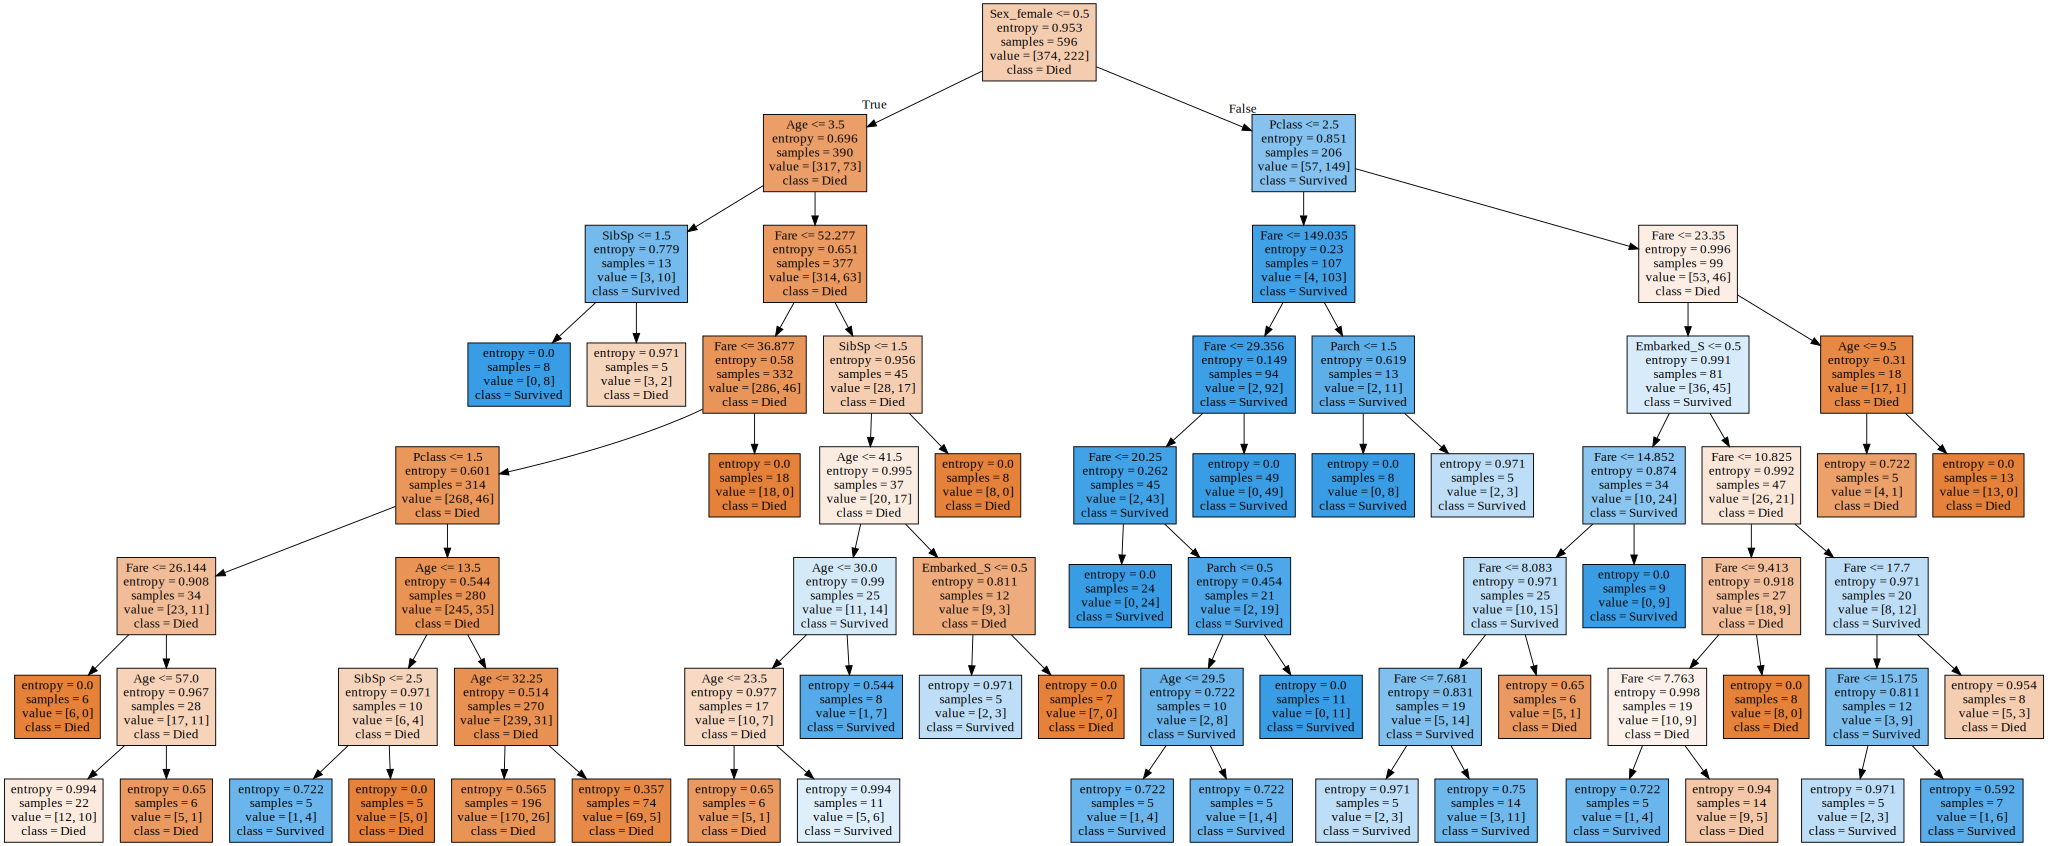

In [89]:
mega_clf = grid_search_cv.best_estimator_
graph = Source(tree.export_graphviz(mega_clf, out_file=None, feature_names=list(X), class_names=['Died', 'Survived'], filled=True))
display(SVG(graph.pipe(format='svg')))

In [91]:
print(mega_clf.score(X_test, y_test))
print(the_best_clf.score(X_test, y_test))
print(best_clf.score(X_test, y_test))
print(clf.score(X_test, y_test))

0.8067796610169492
0.8067796610169492
0.8067796610169492
0.7728813559322034


In [105]:
from sklearn.metrics import precision_score, recall_score, roc_curve, auc

y_predicted = mega_clf.predict(X_test)
print('precision:', precision_score(y_test, y_predicted))
print('recall:', recall_score(y_test, y_predicted))

precision: 0.8058252427184466
recall: 0.6916666666666667


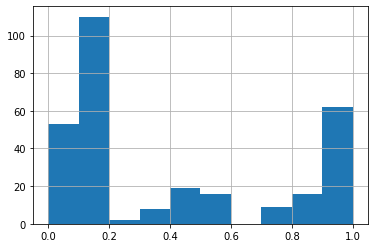

In [113]:
y_predicted_prob = mega_clf.predict_proba(X_test)
pd.Series(y_predicted_prob[:, 1]).hist()

In [148]:
y_tune = np.where(y_predicted_prob[:, 1] > 0.4, 1, 0)
print('precision:', precision_score(y_test, y_tune))
print('recall:', recall_score(y_test, y_tune))

precision: 0.7916666666666666
recall: 0.7916666666666666


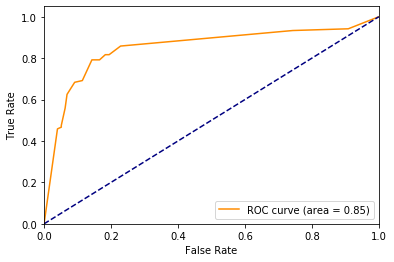

In [149]:
fpr, tpr, thresholds = roc_curve(y_test, y_predicted_prob[:,1])
roc_auc= auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Rate')
plt.ylabel('True Rate')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# from this point we make random forest.

In [151]:
from sklearn.ensemble import RandomForestClassifier

In [178]:
params = {'n_estimators': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19], 'criterion': ['gini', 'entropy'], 'max_depth': [1, 3, 5, 7, 9, 11, 13], 'min_samples_leaf': [1, 3, 5, 7, 9, 11, 13]}

clf_rf = RandomForestClassifier()
grid_search_cv = GridSearchCV(clf_rf, params, cv=5)
grid_search_cv.fit(X_train, y_train)
print(grid_search_cv.best_params_)

{'criterion': 'entropy', 'max_depth': 13, 'min_samples_leaf': 3, 'n_estimators': 9}


In [179]:
mega_clf_rf = grid_search_cv.best_estimator_

In [180]:
mega_clf_rf.score(X_test, y_test)

0.7898305084745763

In [181]:
feature_importance = mega_clf_rf.feature_importances_

In [182]:
features_df = pd.DataFrame({'features': list(X_train), 'feature_importance': feature_importance})

features_df.sort_values('feature_importance', ascending=False)

,features,feature_importance
5,Sex_female,0.265922
4,Fare,0.209870
1,Age,0.171845
0,Pclass,0.116873
6,Sex_male,0.105768
2,SibSp,0.042203
3,Parch,0.036226
9,Embarked_S,0.023644
7,Embarked_C,0.014384
8,Embarked_Q,0.013265


In [183]:
y_predicted = mega_clf_rf.predict(X_test)
print('precision:', precision_score(y_test, y_predicted))
print('recall:', recall_score(y_test, y_predicted))

precision: 0.79
recall: 0.6583333333333333


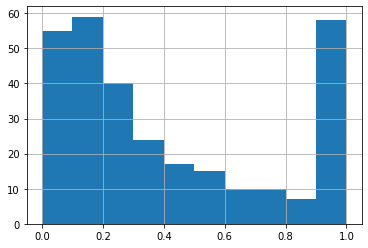

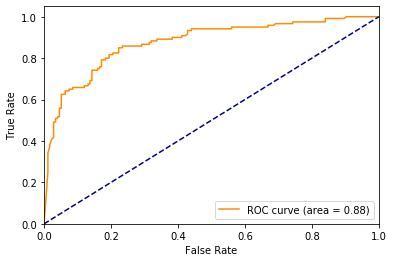

In [184]:
y_predicted_prob = mega_clf_rf.predict_proba(X_test)
pd.Series(y_predicted_prob[:, 1]).hist()

fpr, tpr, thresholds = roc_curve(y_test, y_predicted_prob[:,1])
roc_auc= auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Rate')
plt.ylabel('True Rate')
plt.legend(loc="lower right")
plt.show()